In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import math
import scipy
import re
pd.set_option('display.max_rows',4000)
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
plt.style.use('dark_background')
mpl.rcParams['image.cmap'] = 'bwr'
mpl.rcParams['lines.linewidth'] = 4

In [2]:
def p2f(x):
    return float(x.strip('%'))

def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        try:
            if dataset.dtypes[column] == np.object or dataset.dtypes[column] == '<M8[ns]':
                g = sns.countplot(x=column, data=dataset)
                substrings = [s.get_text()[:18] for s in g.get_xticklabels()]
                g.set(xticklabels=substrings)
                plt.yticks(rotation=0)
                plt.xticks(rotation=90)
            else:
                g = sns.distplot(dataset[column])
                plt.xticks(rotation=0)
        except:
            continue

# Loading all data - EDA

## Age Groups

In [3]:
age = pd.read_csv('covid19-in-india/AgeGroupDetails.csv', index_col='Sno',converters={'Percentage':p2f})
print(age.shape)
age.name='age'
age.head()

(10, 3)


,AgeGroup,TotalCases,Percentage
Sno,,,
1,0-9,22,3.18
2,10-19,27,3.90
3,20-29,172,24.86
4,30-39,146,21.10
5,40-49,112,16.18


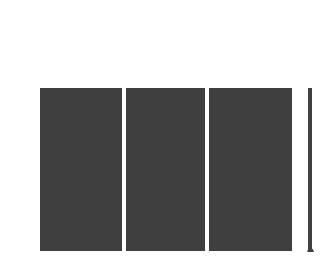

In [4]:
missingno.matrix(age,figsize=(5,3))

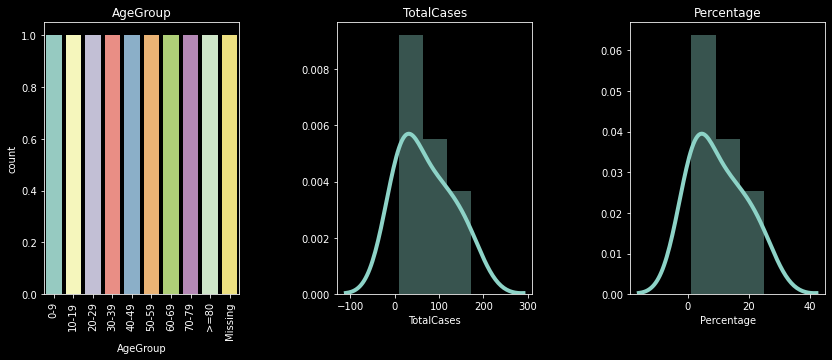

In [5]:
plot_distribution(age,cols=3, width=14, height=5, hspace=0.2, wspace=0.5)
plt.show()

## Total Cases Tally

In [6]:
cases = pd.read_csv('covid19-in-india/covid_19_india.csv', index_col='Sno',parse_dates=True, na_values=['-'])
cases.Date = pd.to_datetime(cases.Date, dayfirst=True)
cases.name='cases'
print(cases.shape)
cases.head()

(1157, 8)


,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
Sno,,,,,,,,
1,2020-01-30,6:00 PM,Kerala,1.0,0.0,0,0,1
2,2020-01-31,6:00 PM,Kerala,1.0,0.0,0,0,1
3,2020-02-01,6:00 PM,Kerala,2.0,0.0,0,0,2
4,2020-02-02,6:00 PM,Kerala,3.0,0.0,0,0,3
5,2020-02-03,6:00 PM,Kerala,3.0,0.0,0,0,3


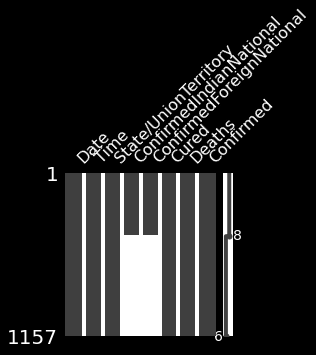

In [7]:
missingno.matrix(cases, figsize=(3,3))

<font face = "Courier New" size = "3" color=Blue> 
__covid_19_india.csv__
- We can see that 'ConfirmedIndianNational', 'ConfirmedForeignNational' have many missing values
- Assuming that there has been no entry of foreign nationals after the last available value, we find number of indian cases as (total confirmed-foreign cases)
</font>

In [8]:
cases.isna().sum()/cases.shape[0]*100

Date                         0.000000
Time                         0.000000
State/UnionTerritory         0.000000
ConfirmedIndianNational     61.452031
ConfirmedForeignNational    61.452031
Cured                        0.000000
Deaths                       0.000000
Confirmed                    0.000000
dtype: float64

In [9]:
cases['ConfirmedForeignNational'] = cases['ConfirmedForeignNational'].fillna(0)
cases['ConfirmedIndianNational']=cases['Confirmed']-cases['ConfirmedForeignNational']
for i,df in cases.groupby('Date'):
    print(cases.groupby('Date').get_group(i).shape[0],end=',')

1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,4,6,6,6,8,8,12,12,12,13,13,13,14,15,15,17,19,20,22,23,23,24,25,27,27,27,27,28,28,29,29,31,30,30,30,31,31,31,31,31,31,32,33,33,33,33,33,33,33,

<font face = "Courier New" size = "3" color=Blue> 
- This tells us that all the states that have cases are listed on a particular date  
- We also know that the counts for each state on any date is cumulative
</font>

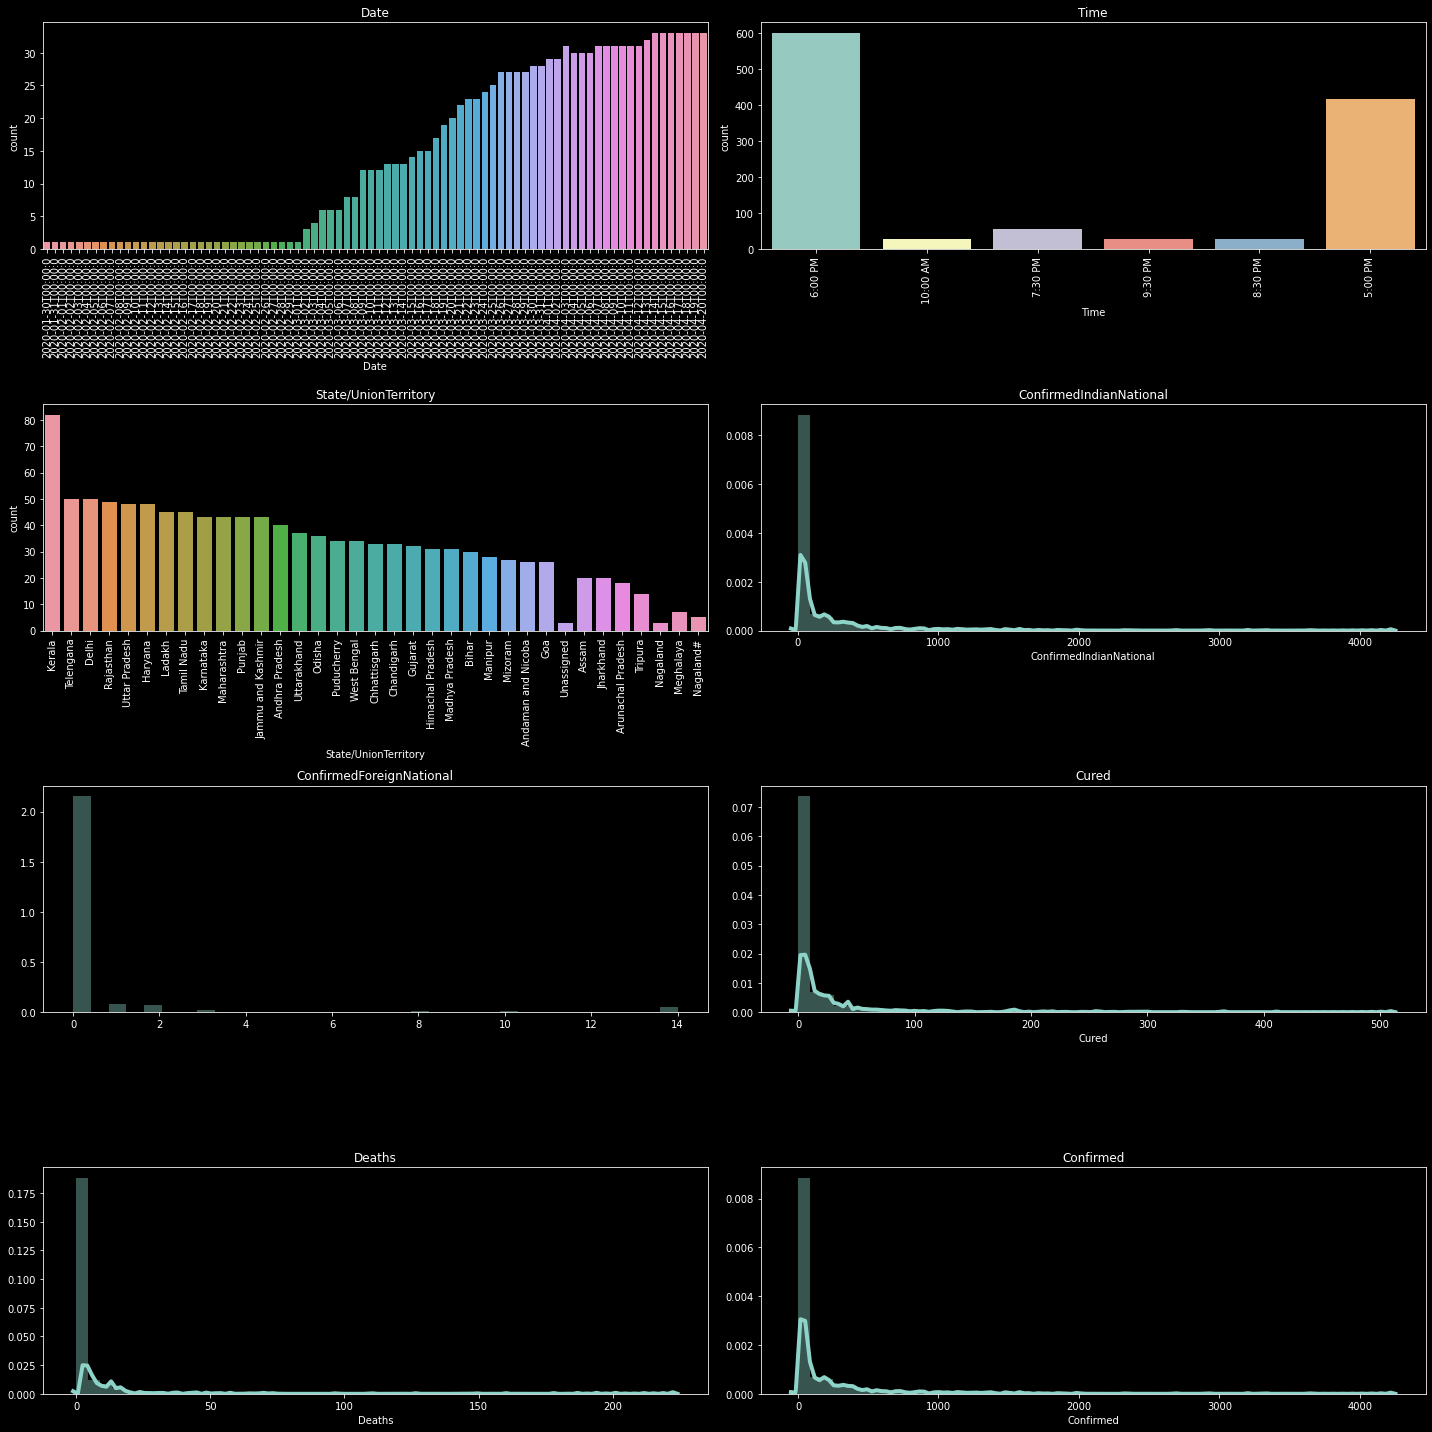

In [10]:
plot_distribution(cases,cols=2, width=20, height=20, hspace=0.2, wspace=0.5)
plt.tight_layout()

<font face = "Courier New" size = "3" color=Blue> 
From these graphs, we can conclude the following:
- There are many reading from the same date, which are of all states with their cumulative covid patient counts on that date
- The number of states reporting cases has gone up and the saturated (figure 1)
- Maximum number of reportings (not cases) come from Kerala. Thus Kerala is the state suffering from covid for the longest (figure 3)
- The frequency distributions for Confirmed cases, Deaths and Cured patients are long tailed
</font>

## Individual Cases

In [11]:
ind = pd.read_csv('covid19-in-india/IndividualDetails.csv', index_col='id',parse_dates=True)
print(ind.shape)
ind.name='ind'

ind['diagnosed_date'] = pd.to_datetime(ind['diagnosed_date'],dayfirst=True )
ind['status_change_date'] = pd.to_datetime(ind['status_change_date'], dayfirst=True)
ind.head()

(18032, 10)


,government_id,diagnosed_date,age,gender,detected_city,detected_district,detected_state,nationality,status_change_date,notes
id,,,,,,,,,,
0,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,India,2020-02-14,Travelled from Wuhan
1,KL-AL-P1,2020-02-02,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,2020-02-14,Travelled from Wuhan
2,KL-KS-P1,2020-02-03,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,2020-02-14,Travelled from Wuhan
3,DL-P1,2020-03-02,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,2020-03-15,"Travelled from Austria, Italy"
4,TS-P1,2020-03-02,24,M,Hyderabad,Hyderabad,Telangana,India,2020-03-02,"Travelled from Dubai to Bangalore on 20th Feb,..."


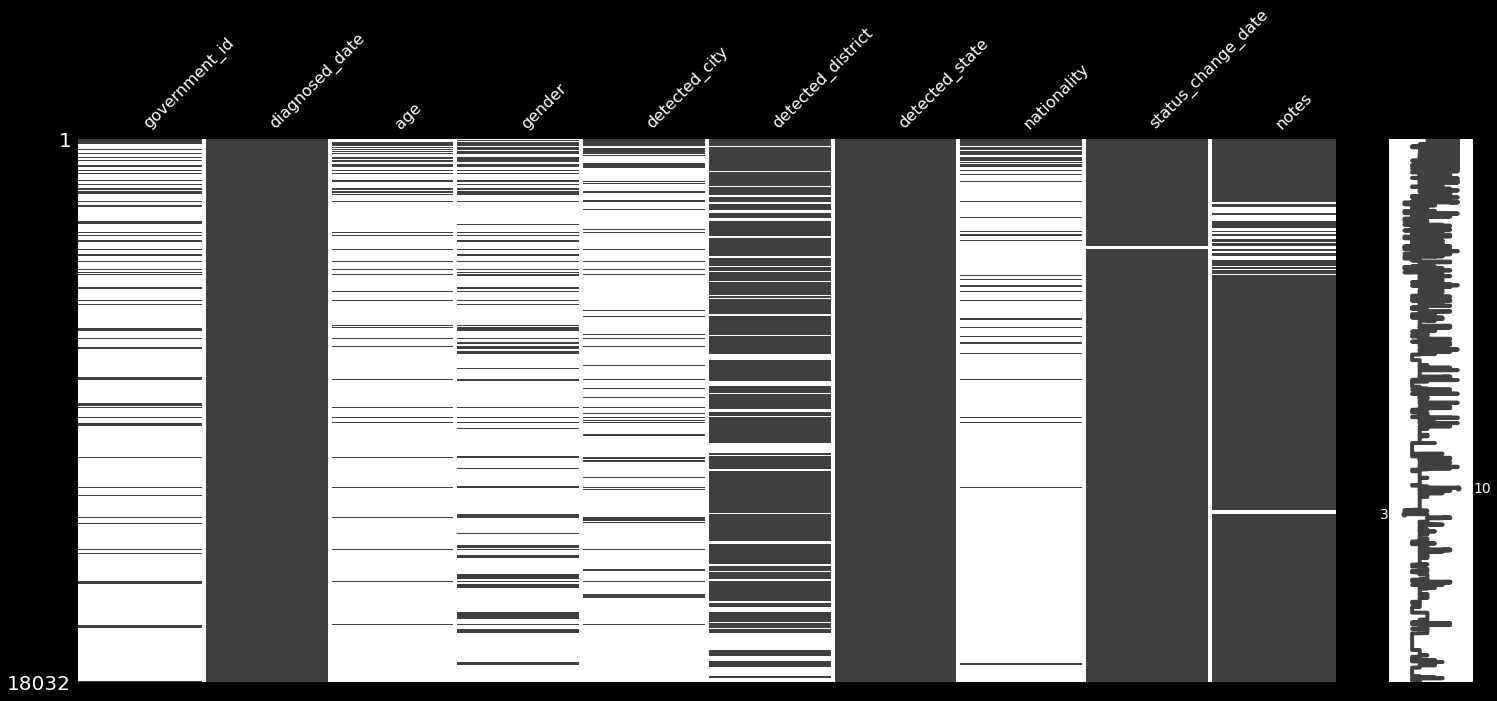

In [12]:
missingno.matrix(ind)

In [13]:
#### Percentage of missing values
ind.isna().sum()/ind.shape[0]*100

government_id         86.035936
diagnosed_date         0.000000
age                   90.572316
gender                78.460515
detected_city         88.004658
detected_district     18.622449
detected_state         0.000000
nationality           91.082520
status_change_date     0.610027
notes                  7.309228
dtype: float64

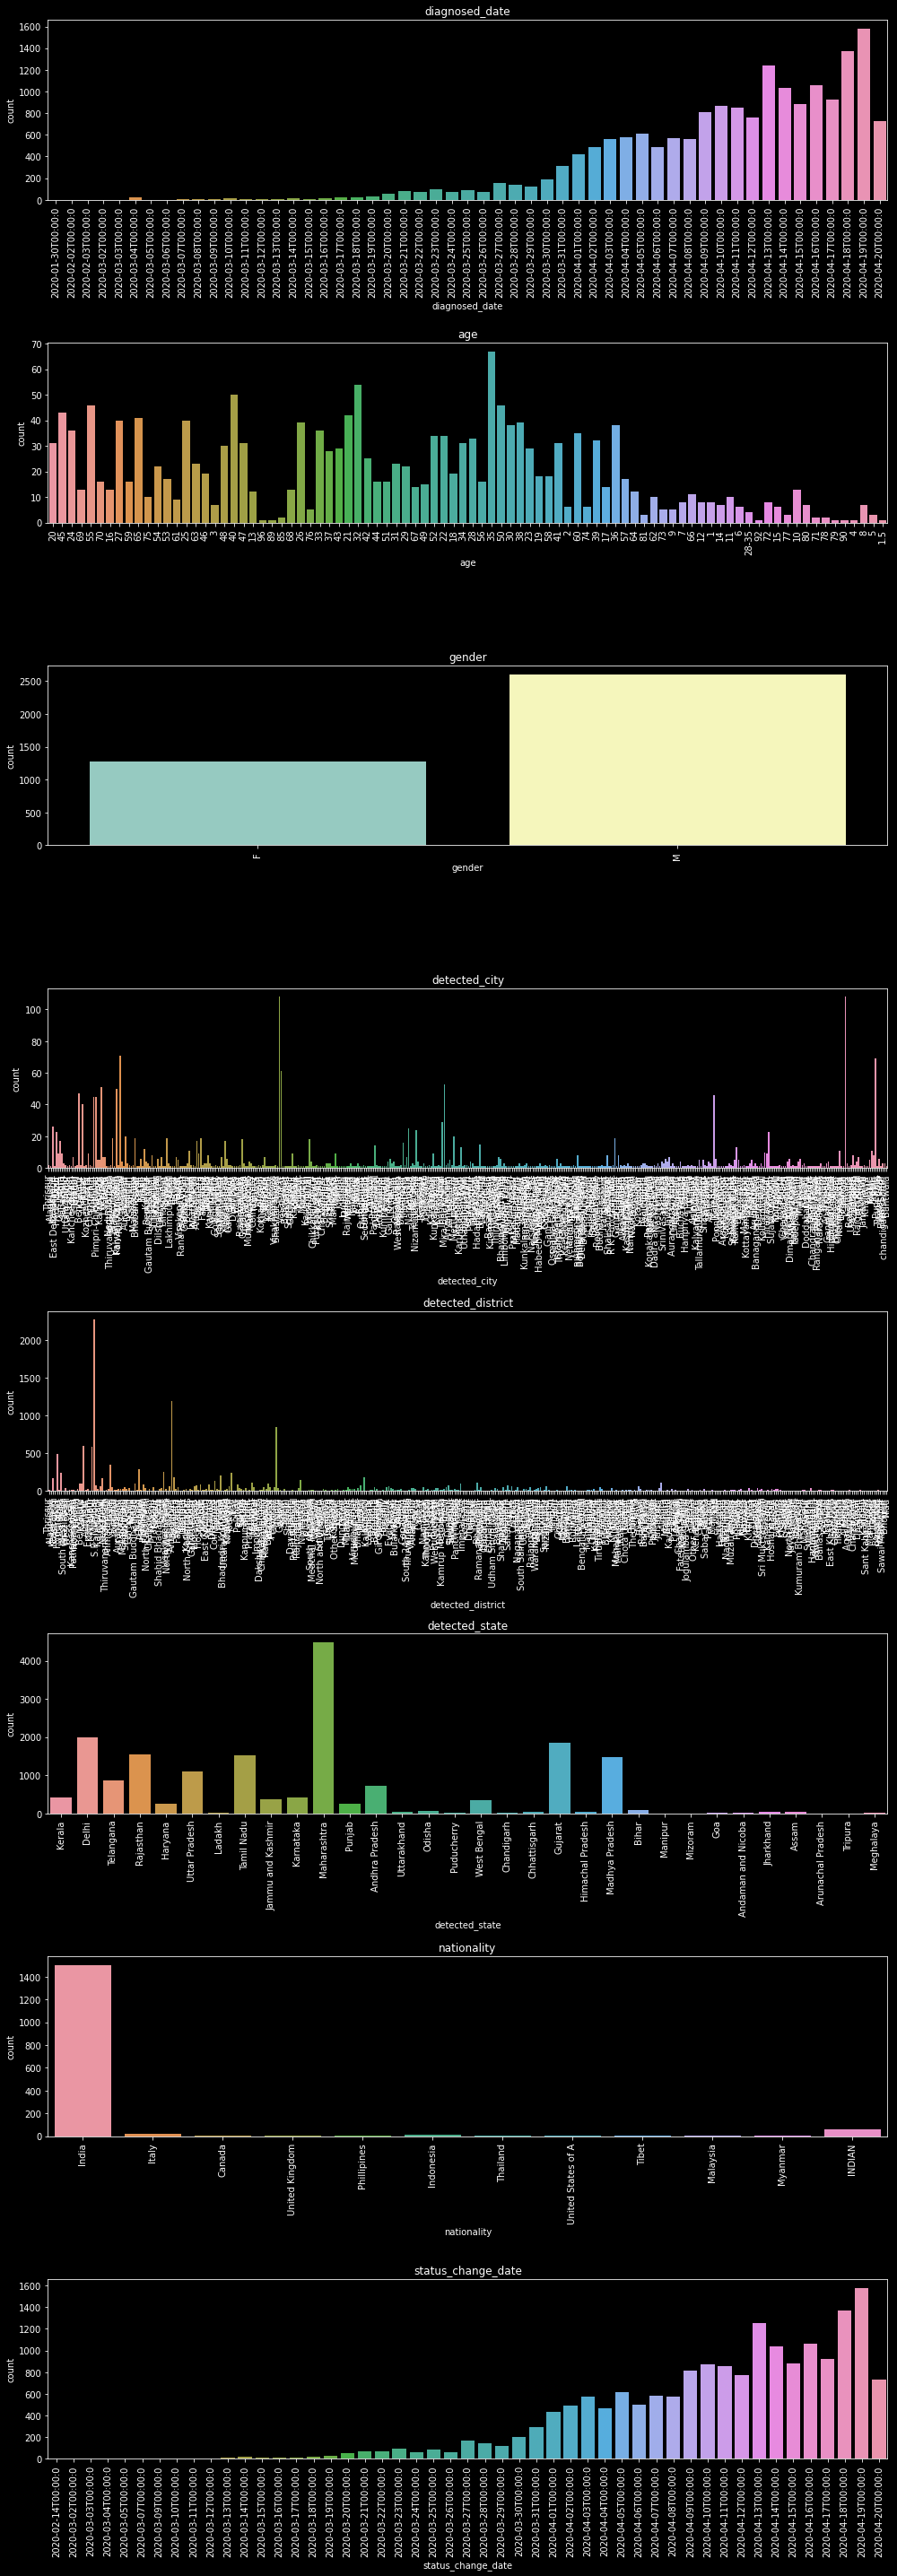

In [14]:
plot_distribution(ind.iloc[:,1:-1], cols=1,width=14,height=40)
plt.tight_layout()

<font face = "Courier New" size = "3" color=Blue> 
__CLEANING DATA__
- Wherever applicable we can fill missing values using the distribution of that column - example: age, gender*, notes
- We can groupby the state and then fill missing values according to the distribution of the column for that state - example: detected_district (detected_state), detected_city(detected_district), nationality(detected_state), gender* 
- We must manually set NaNs in notes to details awaited since we do not know anything about them
- We must manually set the district, city etc. of cases that are contact cases with some govt id
</font>


In [15]:
# replacing gender age, gender,detected_state according to state
# Age
def fill_col(data,column='age'):
    s = data[column].value_counts(normalize=True)
    missing = data[column].isnull()
    try:
        data.loc[missing,column] = np.random.choice(s.index, size=len(data[missing]),p=s.values)
    except:
        pass

In [16]:
##filling detected_state
dict1={}
for i in ind.groupby(['detected_state'],sort=False).groups:
    data = ind.groupby(['detected_state'],sort=False).get_group(i)
    fill_col(data,'gender')
    fill_col(data,'age')
    fill_col(data,'detected_district')
    dict1[i] = data

/home/shan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
for i in dict1:
    print(i)
    print(dict1[i][['age','gender','detected_district']].isna().sum())
    print()

Kerala
age                  0
gender               0
detected_district    0
dtype: int64

Delhi
age                  0
gender               0
detected_district    0
dtype: int64

Telangana
age                  0
gender               0
detected_district    0
dtype: int64

Rajasthan
age                  0
gender               0
detected_district    0
dtype: int64

Haryana
age                  0
gender               0
detected_district    0
dtype: int64

Uttar Pradesh
age                  0
gender               0
detected_district    0
dtype: int64

Ladakh
age                  0
gender               0
detected_district    0
dtype: int64

Tamil Nadu
age                  0
gender               0
detected_district    0
dtype: int64

Jammu and Kashmir
age                  0
gender               0
detected_district    0
dtype: int64

Karnataka
age                  0
gender               0
detected_district    0
dtype: int64

Maharashtra
age                  0
gender               0
detected_di

<font face = "Courier New" size = "3" color=Blue> 
- We notice that even after filling the columns, Arunachal Pradesh has missing value, for gender and age
- Since the mode gender is Male and mode age is 35, we fill that in
</font>

In [18]:
dict1['Arunachal Pradesh'].age=35
dict1['Arunachal Pradesh'].gender='M'
dict1['Arunachal Pradesh'].detected_city='Lohit'

/home/shan/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:
df=pd.concat(dict1.values(), ignore_index=True)

In [20]:
## filling detected_city
dict2={}
for i in df.groupby(['detected_state','detected_district']).groups:
    data = df.groupby(['detected_state','detected_district']).get_group(i)
    fill_col(data,'detected_city')
    dict2[i] = data

In [21]:
for i in dict2:
    print(i)
    print(dict2[i][['age','gender','detected_district','detected_city']].isna().sum()/dict2[i].shape[0]*100)
    print()

('Andaman and Nicobar Islands', 'North and Middle Andaman')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Andaman and Nicobar Islands', 'South Andaman')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Andhra Pradesh', 'Anantapur')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Andhra Pradesh', 'Chittoor')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Andhra Pradesh', 'East Godavari')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Andhra Pradesh', 'Guntur')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Andhra Pradesh', 'Krishna')
age                  0.0
gend

age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Gujarat', 'Dahod')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Gujarat', 'Gandhinagar')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Gujarat', 'Gir Somnath')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Gujarat', 'Jamnagar')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Gujarat', 'Kachchh')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Gujarat', 'Kheda')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Guj

dtype: float64

('Jharkhand', 'Hazaribagh')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Jharkhand', 'Kodarma')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Jharkhand', 'Ranchi')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Jharkhand', 'Simdega')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Karnataka', 'Bagalkote')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Karnataka', 'Ballari')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Karnataka', 'Belagavi')
age                  0.0
gender               0.0
detected_district    0.0
detected_

dtype: float64

('Madhya Pradesh', 'Shivpuri')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Madhya Pradesh', 'Tikamgarh')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Madhya Pradesh', 'Ujjain')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Madhya Pradesh', 'Vidisha')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Maharashtra', 'Ahmadnagar')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Maharashtra', 'Akola')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Maharashtra', 'Amravati')
age                  0.0
gender               0.0
d

dtype: float64

('Rajasthan', 'Evacuees*')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Rajasthan', 'Hanumangarh')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Rajasthan', 'Italians*')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Rajasthan', 'Jaipur')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Rajasthan', 'Jaisalmer')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Rajasthan', 'Jhalawar')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Rajasthan', 'Jhunjhunu')
age                  0.0
gender               0.0
detected_district    0.0
de

dtype: float64

('Uttar Pradesh', 'Bijnor')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Uttar Pradesh', 'Budaun')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Uttar Pradesh', 'Bulandshahr')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Uttar Pradesh', 'Etawah')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Uttar Pradesh', 'Firozabad')
age                    0.0
gender                 0.0
detected_district      0.0
detected_city        100.0
dtype: float64

('Uttar Pradesh', 'Gautam Buddha Nagar')
age                  0.0
gender               0.0
detected_district    0.0
detected_city        0.0
dtype: float64

('Uttar Pradesh', 'Ghaziabad')
age                  0.0
gen

In [22]:
clean_ind=pd.concat(dict2.values(), ignore_index=True)
clean_ind.detected_city.fillna(clean_ind.detected_district,inplace=True)


In [23]:
clean_ind.nationality.fillna('India',inplace=True)

In [24]:
clean_ind['nationality'].replace('INDIAN', 'India',inplace=True)

In [25]:
clean_ind.notes.fillna('Details Awaited',inplace=True)
clean_ind.notes.replace('Details awaited', 'Details Awaited',inplace=True)

In [26]:
clean_ind = clean_ind.drop('government_id',axis=1)
clean_ind.sort_values(by='diagnosed_date',inplace=True)

<font face = "Courier New" size = "4" color=Maroon> 
SUMMARY
IndividualDetails.csv
</font>
<font face = "Courier New" size = "3" color=Blue> 
- There are no missing States values
- For each state, there are some districts mentioned and others are null values. The districts are filled in according to the existing distribution of districts for each state. Gender and Age are also filled this way. 
- Even after doing this, Arunachal Pradesh had a district with only one case with no age, gender. Thus was imputed with the mode of the overall data 
- After this, cities were filled in according to the distribution of cities in each district.
- Even after this, there were districts that had no cities filled in them. For these cases, the city was set as the district
- Nationality was assumed to be Indian for those cases where not mentioned. Variations of the same nationality were standardised. Eg. Indian to India
- Notes that were not mentioned have been set as 'Details Awaited'
</font>

In [27]:
clean_ind['label']=np.nan

In [28]:
clean_ind.loc[clean_ind.status_change_date<clean_ind.diagnosed_date].shape

(60, 10)

In [29]:
clean_ind.loc[clean_ind.status_change_date<=clean_ind.diagnosed_date,'label']='Positive'

In [30]:
clean_ind.label.fillna('Recovered/Dead',inplace=True)

In [31]:
clean_ind.label.value_counts()

Positive          17731
Recovered/Dead      301
Name: label, dtype: int64

## Hospital Beds in India

In [32]:
beds = pd.read_csv('covid19-in-india/HospitalBedsIndia.csv', index_col='Sno',thousands=',')
print(beds.shape)
beds.name='beds'
beds.head()

(37, 11)


,State/UT,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18
Sno,,,,,,,,,,,
1,Andaman & Nicobar Islands,27,4,NaN,3,34,1246,27,575,3,500
2,Andhra Pradesh,1417,198,31.0,20,1666,60799,193,6480,65,16658
3,Arunachal Pradesh,122,62,NaN,15,199,2320,208,2136,10,268
4,Assam,1007,166,14.0,33,1220,19115,1176,10944,50,6198
5,Bihar,2007,63,33.0,43,2146,17796,930,6083,103,5936


In [33]:
beds.isna().sum()/beds.shape[0]*100

State/UT                             0.000000
NumPrimaryHealthCenters_HMIS         0.000000
NumCommunityHealthCenters_HMIS       0.000000
NumSubDistrictHospitals_HMIS        18.918919
NumDistrictHospitals_HMIS            0.000000
TotalPublicHealthFacilities_HMIS     0.000000
NumPublicBeds_HMIS                   0.000000
NumRuralHospitals_NHP18              0.000000
NumRuralBeds_NHP18                   0.000000
NumUrbanHospitals_NHP18              0.000000
NumUrbanBeds_NHP18                   0.000000
dtype: float64

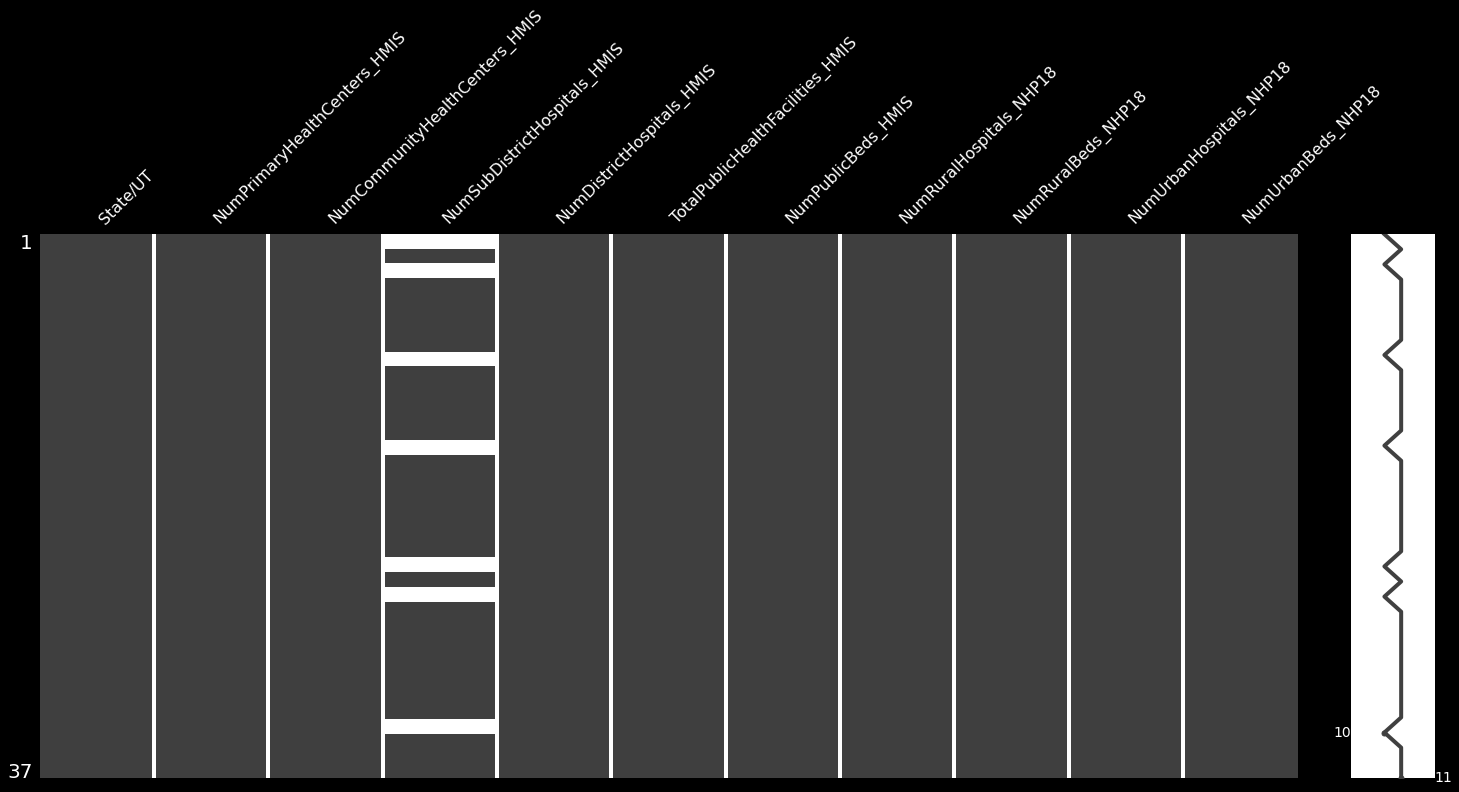

In [34]:
missingno.matrix(beds)

In [35]:
print('Sum:',beds['NumSubDistrictHospitals_HMIS'].iloc[:-1].sum())
print('Total:',beds['NumSubDistrictHospitals_HMIS'].iloc[-1])

Sum: 1255.0
Total: 1255.0


<font face = "Courier New" size = "3" color=Blue> 
- NumSubDistrictHospitals_HMIS has has 19% missing values, however, on adding the remaining values, it equals the last row All India value. Thus, the NaN values must be replaced with zero
</font>

In [36]:
beds.fillna(0,inplace=True)

## ICMR Testing Details

In [37]:
icmr= pd.read_csv('covid19-in-india/ICMRTestingDetails.csv', delimiter='\t', index_col='SNo',parse_dates=True)
print(icmr.shape)
icmr.name='icmr'
icmr

(16, 5)


,DateTime,TotalSamplesTested,TotalIndividualsTested,TotalPositiveCases,Source
SNo,,,,,
1,13-03-2020 00:00,6500,5900,78,Press_Release_ICMR_13March2020.pdf
2,18-03-2020 18:00,13125,12235,150,ICMR_website_update_18March_6PM_IST.pdf
3,19-03-2020 10:00,13316,12426,168,ICMR_website_update_19March_10AM_IST_V2.pdf
4,19-03-2020 18:00,14175,13285,182,ICMR_website_update_19March_6PM_IST.pdf
5,20-03-2020 10:00,14376,13486,206,ICMR_website_update_20March_10AM_IST.pdf
6,20-03-2020 18:00,15404,14514,236,ICMR_website_update_20March_6PM_IST.pdf
7,21-03-2020 10:00,15701,14811,271,ICMR_website_update_21March_10AM_IST.pdf
8,21-03-2020 18:00,16911,16021,315,ICMR_website_update_21March_6PM_IST.pdf
9,22-03-2020 10:00,16999,16109,341,ICMR_website_update_22March_10AM_IST.pdf


In [38]:
icmr['DateTime']=pd.to_datetime(icmr['DateTime']).dt.date
icmr=icmr.drop('Source',axis=1)
icmr['DateTime']=pd.to_datetime(icmr['DateTime'])
icmr.info()   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 1 to 16
Data columns (total 4 columns):
DateTime                  16 non-null datetime64[ns]
TotalSamplesTested        16 non-null int64
TotalIndividualsTested    16 non-null int64
TotalPositiveCases        16 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 640.0 bytes


In [39]:
s = icmr.resample('D', on='DateTime').sum().reset_index()
icmr=s.drop([1,2,3,4],axis=0)

## Census

In [40]:
census = pd.read_csv('covid19-in-india/population_india_census2011.csv', index_col='Sno')
print(census.shape)
census.head()

(36, 7)


,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
Sno,,,,,,,
1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


In [41]:
census.isna().sum()

State / Union Territory    0
Population                 0
Rural population           0
Urban population           0
Area                       0
Density                    0
Gender Ratio               0
dtype: int64

# Q1
<font face = "Courier New" size = "4" color=Deeppink> 
- Which age group is the most infected?

Text(0.5, 1.0, 'Percentage of Affected Patients by Age-Group')

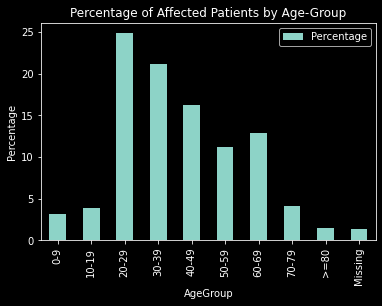

In [42]:
age.plot('AgeGroup','Percentage',kind='bar')
plt.ylabel('Percentage')
plt.title('Percentage of Affected Patients by Age-Group')

# Q2
<font face = "Courier New" size = "4" color=deeppink> 
- Plot graphs of the cases observed, recovered, deaths per day:
    - country-wise 
    - state-wise

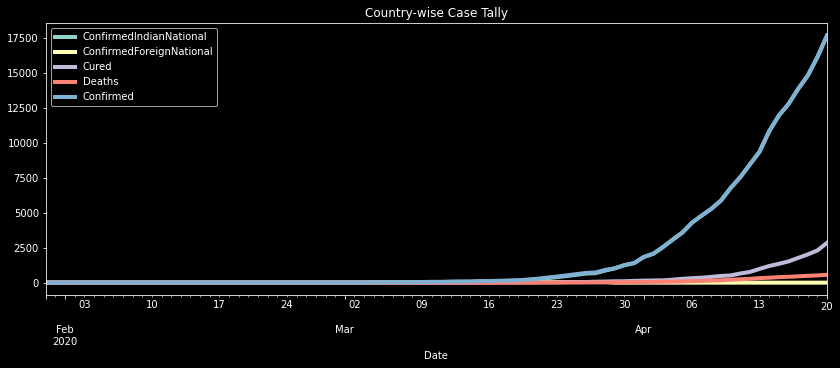

In [43]:
country_cases=cases.resample('D', on='Date').sum()
country_cases.plot(figsize=(14,5))
plt.title('Country-wise Case Tally')
plt.show()

<font face = "Courier New" size = "3" color=Blue> 
- The number of confirmed cases has been rising steeply (exponentially)
- The number of cured cases is also rising steeply however it is less steep than number of confirmed cases
- Number of deaths is approximately linear
</font>

/home/shan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/shan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/shan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface 

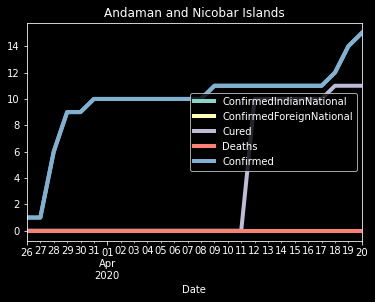

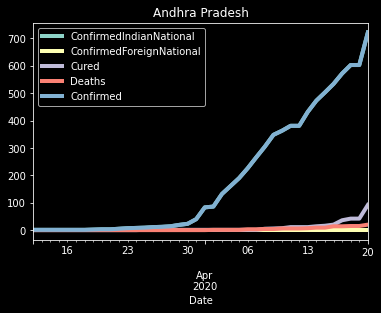

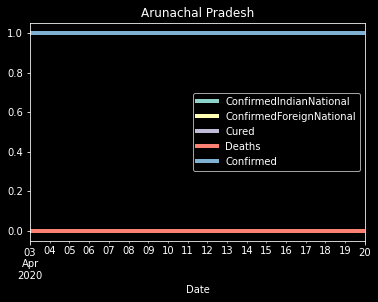

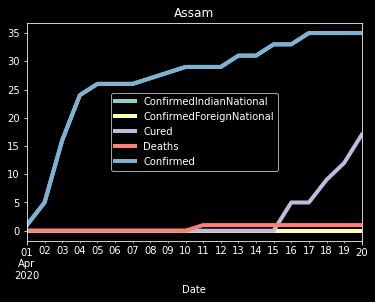

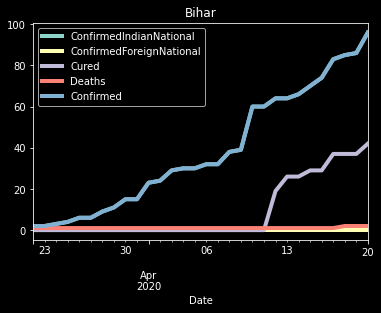

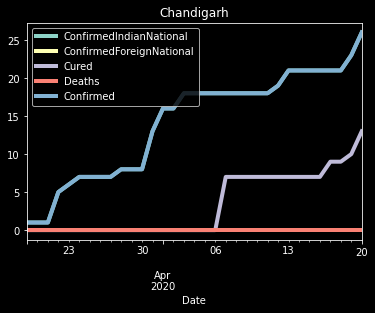

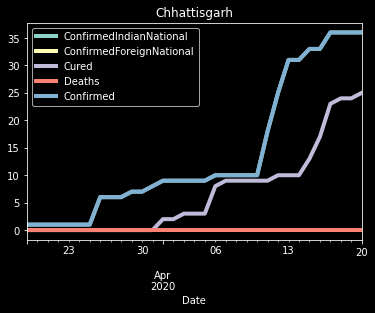

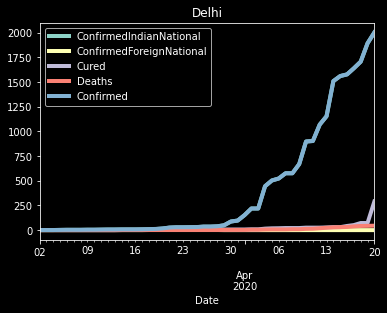

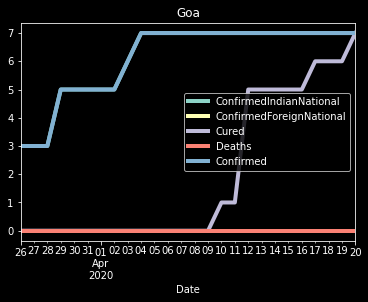

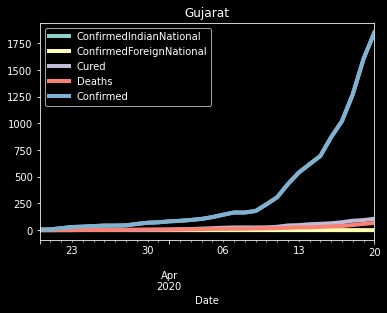

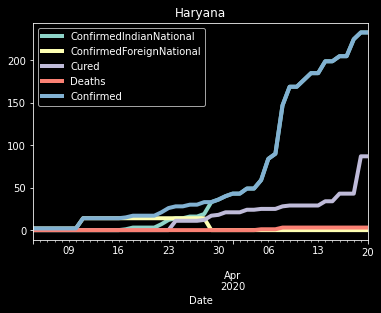

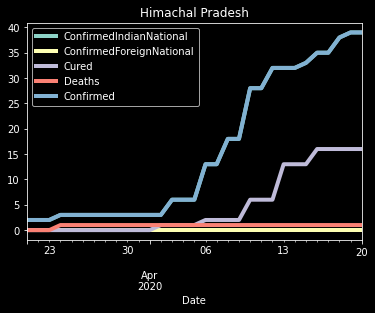

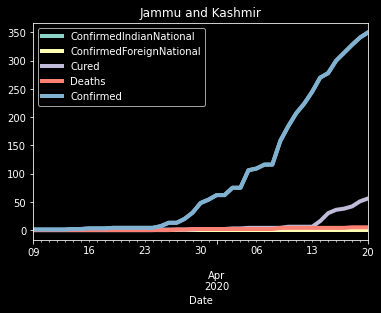

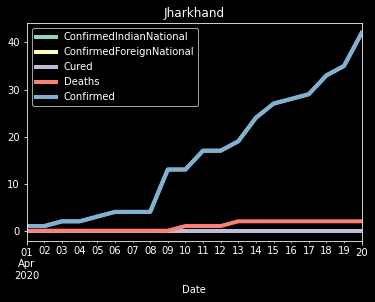

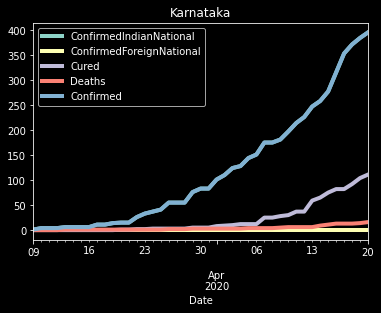

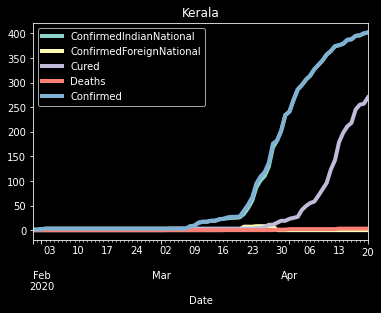

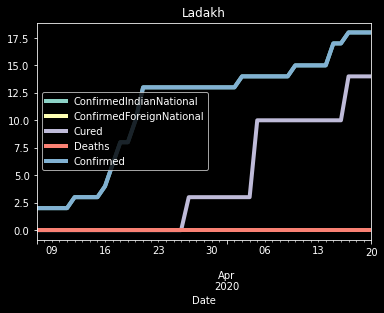

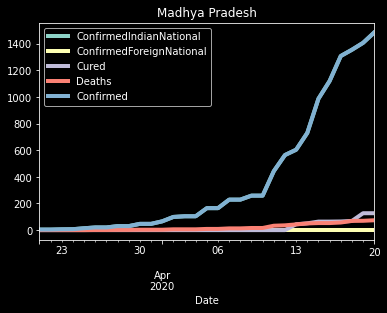

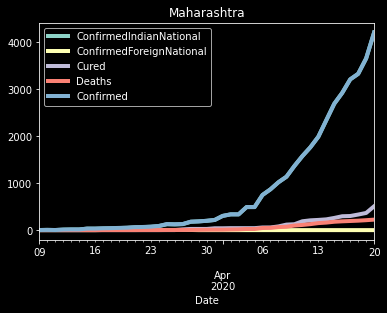

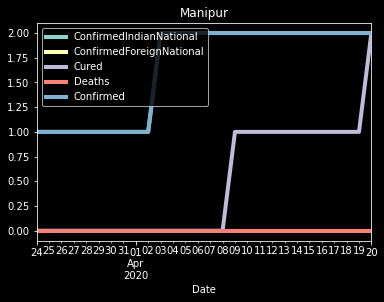

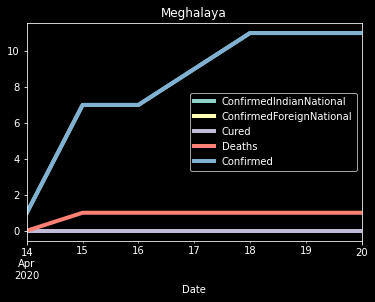

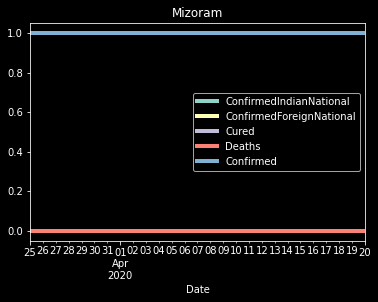

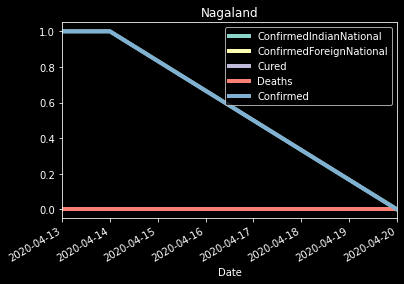

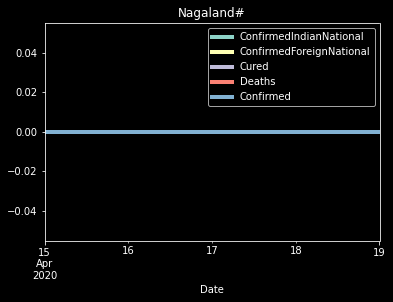

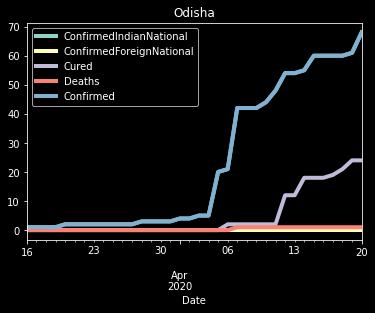

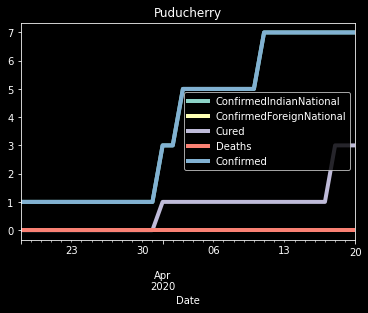

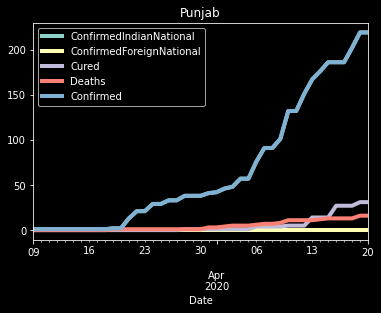

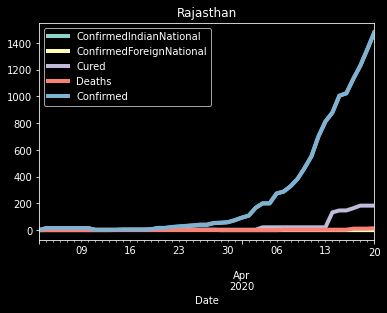

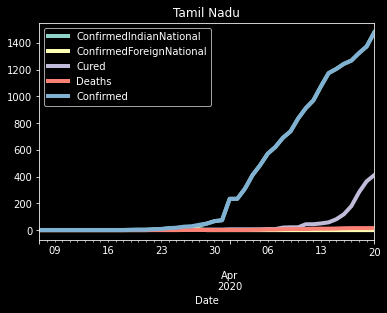

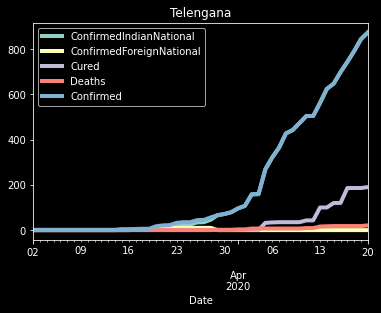

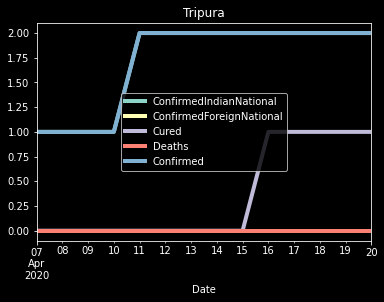

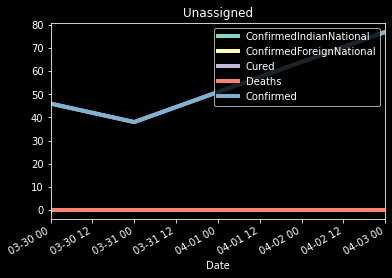

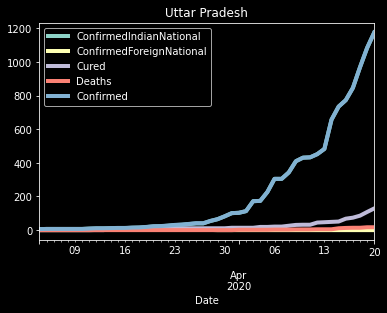

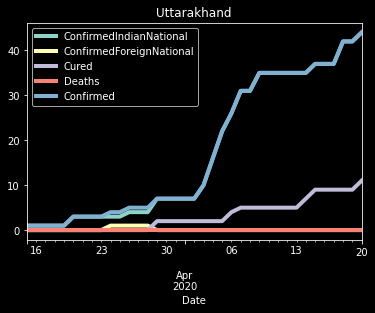

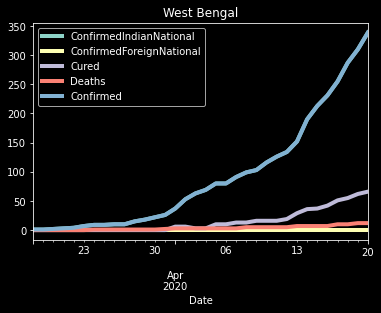

In [44]:
grouped = cases.groupby('State/UnionTerritory')
for name,df in grouped:
    i=cases.groupby('State/UnionTerritory').get_group(name)
    i.plot("Date",title=name)
plt.show()


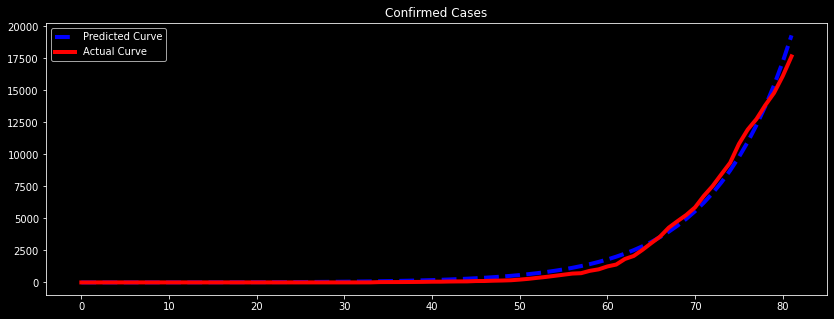

In [45]:
############## CURVE FITTING ON TOTAL CONFIRMED CASES DATA ##########################
y = country_cases.Confirmed.values
x=np.arange(y.shape[0])

a1,b1=np.polyfit(x, np.log(y), 1, w=np.sqrt(0.5*y**1.5))
ypred=np.exp(a1*x + b1)

plt.figure(figsize=(14,5))
plt.title("Confirmed Cases")
plt.plot(x, ypred, 'b--',label='Predicted Curve')
plt.plot(x,y,'r',label='Actual Curve')
plt.legend()
plt.show()

In [46]:
print('Predicted Curve: {0:.2f}*exp({1:.2f}*x)'.format(np.exp(b1),a1))
print('R2 Score of the fit is',r2_score(y, ypred))

Predicted Curve: 2.04*exp(0.11*x)
R2 Score of the fit is 0.9916682702012082


<font face = "Courier New" size = "3" color=Blue> 
- After performing curve fitting, we get an exponential graph : 2.04 e^(0.11x) where x is the numberof days since the first covid case in India
- R2 Score of the fit is 0.99

</font>

# Q3
<font face = "Courier New" size = "4" color=deeppink> 
- Identify the positive cases on a state level
- Quantify the intensity of virus spread for each state*

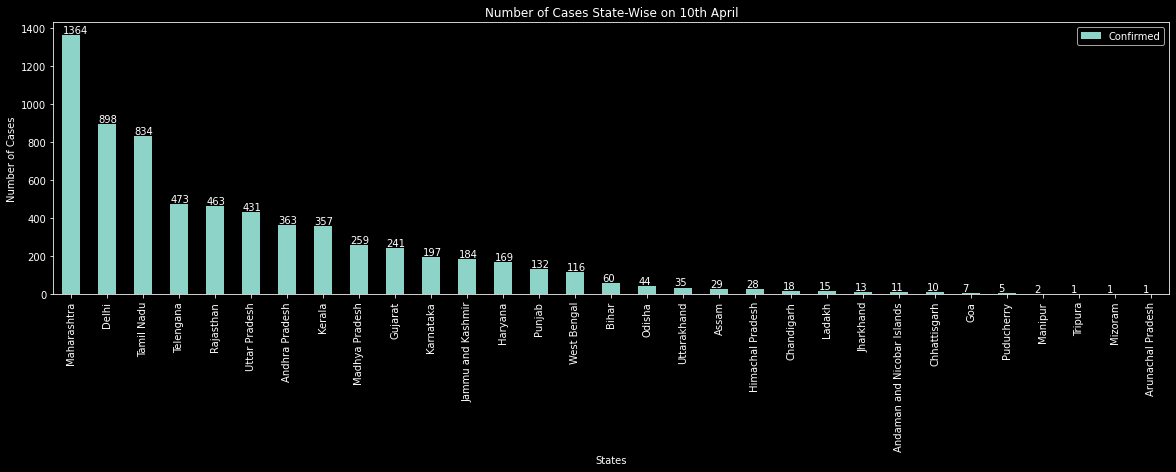

In [47]:
april10=cases.groupby('Date').get_group('2020-04-10')
ax=april10.sort_values(by='Confirmed',ascending=False).plot('State/UnionTerritory','Confirmed',kind='bar',title='Number of Cases State-Wise on 10th April',
                                    figsize=(20,5))
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2),(p.get_x(), p.get_height()+10))
ax.set_xlabel("States")
ax.set_ylabel('Number of Cases')
plt.show()

<font face = "Courier New" size = "3" color=Blue> 
- As of 10th April, Maharashtra has the maximum number of cases closely followed by Delhi

</font>

In [48]:
df = pd.merge(cases, census, left_on='State/UnionTerritory', right_on='State / Union Territory')
df.set_index('Date',inplace=True)
df=df.loc[:'2020-04-10'] ##considering cases only till 10th april

In [49]:
df=df.sort_values(by=['Date']).drop_duplicates(subset='State/UnionTerritory', keep='last')
df.head()

,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
Date,,,,,,,,,,,,,,
2020-04-10,5:00 PM,Karnataka,197.0,0.0,30,6,197,Karnataka,61095297,37469335,23625962,"191,791 km2 (74,051 sq mi)",319/km2 (830/sq mi),973
2020-04-10,5:00 PM,Delhi,898.0,0.0,25,13,898,Delhi,16787941,419042,16368899,"1,484 km2 (573 sq mi)","11,297/km2 (29,260/sq mi)",868
2020-04-10,5:00 PM,Jharkhand,13.0,0.0,0,1,13,Jharkhand,32988134,25055073,7933061,"79,714 km2 (30,778 sq mi)","414/km2 (1,070/sq mi)",948
2020-04-10,5:00 PM,Arunachal Pradesh,1.0,0.0,0,0,1,Arunachal Pradesh,1383727,1066358,317369,"83,743 km2 (32,333 sq mi)",17/km2 (44/sq mi),938
2020-04-10,5:00 PM,Rajasthan,463.0,0.0,21,3,463,Rajasthan,68548437,51500352,17048085,"342,239 km2 (132,139 sq mi)",201/km2 (520/sq mi),928


In [50]:
df = df.drop('State / Union Territory',axis=1)

In [51]:
df['Density']=df['Density'].str.split('/').apply(lambda x: x[0])
df['Density']=df['Density'].str.replace(',', '').astype(float)

In [52]:
df['Intensity'] = df['Confirmed']/df['Density']
df.head()

,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,Population,Rural population,Urban population,Area,Density,Gender Ratio,Intensity
Date,,,,,,,,,,,,,,
2020-04-10,5:00 PM,Karnataka,197.0,0.0,30,6,197,61095297,37469335,23625962,"191,791 km2 (74,051 sq mi)",319.0,973,0.617555
2020-04-10,5:00 PM,Delhi,898.0,0.0,25,13,898,16787941,419042,16368899,"1,484 km2 (573 sq mi)",11297.0,868,0.079490
2020-04-10,5:00 PM,Jharkhand,13.0,0.0,0,1,13,32988134,25055073,7933061,"79,714 km2 (30,778 sq mi)",414.0,948,0.031401
2020-04-10,5:00 PM,Arunachal Pradesh,1.0,0.0,0,0,1,1383727,1066358,317369,"83,743 km2 (32,333 sq mi)",17.0,938,0.058824
2020-04-10,5:00 PM,Rajasthan,463.0,0.0,21,3,463,68548437,51500352,17048085,"342,239 km2 (132,139 sq mi)",201.0,928,2.303483


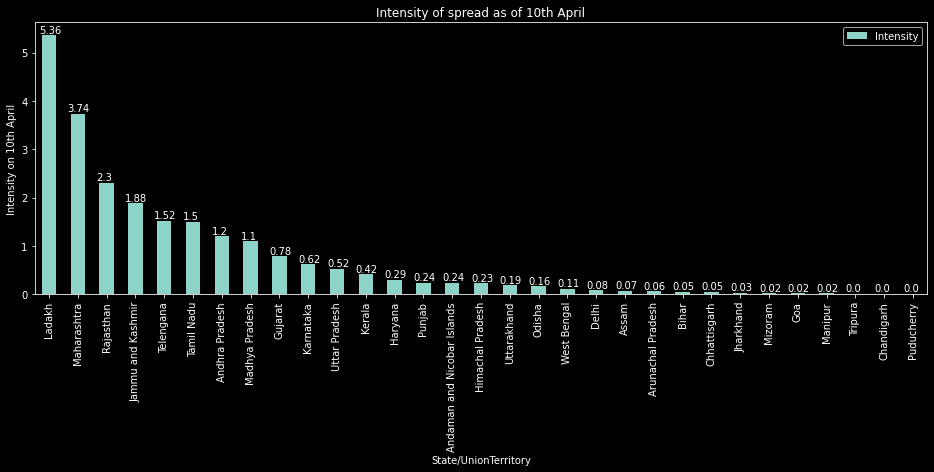

In [53]:
ax=df.sort_values(by='Intensity',ascending=False).plot(x='State/UnionTerritory',y='Intensity', kind='bar',figsize=(16,5))
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2),(p.get_x()-0.1, p.get_height()+0.05))
plt.title('Intensity of spread as of 10th April')
plt.ylabel('Intensity on 10th April')
plt.show()

# Q4
<font face = "Courier New" size = "4" color=deeppink> 
- List places in the country which are active hotspots/clusters as on 10.04.2020*
    
Hotspot is defined as an area in a city where 10 or more people have been tested
positive.

In [54]:
clean_ind.tail()

,diagnosed_date,age,gender,detected_city,detected_district,detected_state,nationality,status_change_date,notes,label
10727,2020-04-20,49,M,MCGM,Mumbai,Maharashtra,India,2020-04-20,Details Awaited,Positive
10726,2020-04-20,27,M,MCGM,Mumbai,Maharashtra,India,2020-04-20,Details Awaited,Positive
10725,2020-04-20,73,M,Mumbai Suburb,Mumbai,Maharashtra,India,2020-04-20,Details Awaited,Positive
10738,2020-04-20,21,M,MCGM,Mumbai,Maharashtra,India,2020-04-20,Details Awaited,Positive
5089,2020-04-20,56,F,Anantnag,Anantnag,Jammu and Kashmir,India,2020-04-20,Details Awaited,Positive


In [55]:
clean_ind.set_index('diagnosed_date',inplace=True)
april10th=clean_ind.loc[:'2020-04-10'].reset_index()
clean_ind.reset_index(inplace=True)

In [56]:
list_cities=pd.DataFrame(april10th.detected_city.value_counts()).reset_index()
list_cities.loc[list_cities.detected_city>=10]

,index,detected_city
0,MCGM,656
1,Nizamuddin area,427
2,Mumbai,284
3,Indore,235
4,Delhi,166
5,Kasaragod,149
6,Hyderabad,145
7,Ramganj,132
8,Ahmedabad,130
9,Bhopal,116


# Q5
<font face = "Courier New" size = "4" color=deeppink> 
- Which states have the maximum change (consider increase and decrease separately)
in number of hotspots on weekly basis from 20.03.2020 to 10.04.2020 (3 weeks).

In [57]:
def hotspot(dataset): 
    vc=pd.DataFrame(dataset.detected_city.value_counts()).reset_index() #finds the counts of number of cases in each city 
    hotspot=vc.loc[vc.detected_city>=10] 
    hotspot=hotspot.merge(clean_ind, left_on='index',right_on='detected_city')
    #print(hotspot.columns)
    hotspot= hotspot[['index','detected_state','detected_city_x']]
    hotspot.drop_duplicates(inplace=True)
    return hotspot.detected_state.value_counts()

<font face = "Courier New" size = "3" color=Blue> 
- 20th march - 26th march -> week 1 
- 27th march - 3rd april -> week 2
- 4th april - 10th april -> week 3
    

In [58]:
clean_ind.set_index('diagnosed_date',inplace=True)
week2=clean_ind.loc[:'2020-04-03'].reset_index()
week3=clean_ind.loc[:'2020-04-10'].reset_index()
week1=clean_ind.loc[:'2020-03-26'].reset_index()
clean_ind.reset_index(inplace=True)

In [59]:
hotspot1=hotspot(week1)
hotspot2=hotspot(week2)
hotspot3=hotspot(week3)

In [60]:
hotspot1

Maharashtra      3
Kerala           2
Telangana        1
Gujarat          1
Delhi            1
Punjab           1
Karnataka        1
Rajasthan        1
Haryana          1
Uttar Pradesh    1
Name: detected_state, dtype: int64

In [61]:
hotspot2

Tamil Nadu           16
Maharashtra          12
Delhi                10
Telangana             6
Rajasthan             5
Uttar Pradesh         5
Gujarat               5
Kerala                4
Andhra Pradesh        2
Karnataka             2
West Bengal           2
Jammu and Kashmir     2
Madhya Pradesh        2
Uttarakhand           1
Chandigarh            1
Haryana               1
Punjab                1
Name: detected_state, dtype: int64

In [62]:
hotspot3

Tamil Nadu                     33
Maharashtra                    20
Telangana                      17
Delhi                          14
Rajasthan                      14
Uttar Pradesh                  11
Jammu and Kashmir              10
Gujarat                         8
Punjab                          8
Madhya Pradesh                  6
Andhra Pradesh                  6
Kerala                          6
West Bengal                     4
Haryana                         4
Karnataka                       3
Chhattisgarh                    1
Uttarakhand                     1
Odisha                          1
Himachal Pradesh                1
Chandigarh                      1
Bihar                           1
Andaman and Nicobar Islands     1
Name: detected_state, dtype: int64

In [63]:
print('Changes in number of hotspots from week 1 to week 2')
((pd.DataFrame(hotspot2) - pd.DataFrame(hotspot1)).fillna(pd.DataFrame(hotspot3))).sort_values(by='detected_state',ascending=False)

Changes in number of hotspots from week 1 to week 2


,detected_state
Tamil Nadu,33.0
Jammu and Kashmir,10.0
Delhi,9.0
Maharashtra,9.0
Andhra Pradesh,6.0
Madhya Pradesh,6.0
Telangana,5.0
Rajasthan,4.0
Gujarat,4.0
Uttar Pradesh,4.0


In [64]:
print('Changes in number of hotspots from week 2 to week 3')
((pd.DataFrame(hotspot3) - pd.DataFrame(hotspot2)).fillna(pd.DataFrame(hotspot3))).sort_values(by='detected_state',ascending=False)

Changes in number of hotspots from week 2 to week 3


,detected_state
Tamil Nadu,17.0
Telangana,11.0
Rajasthan,9.0
Maharashtra,8.0
Jammu and Kashmir,8.0
Punjab,7.0
Uttar Pradesh,6.0
Delhi,4.0
Andhra Pradesh,4.0
Madhya Pradesh,4.0


# Q6
<font face = "Courier New" size = "4" color=deeppink> 
- For the given data, identify cases:
    - with international travel history (primary case)
    - personal contact with primary case (secondary case)
    - Cases which do not fall in the primary and secondary fall into tertiary case  
         
- Quantify them based on the percentage for the top 5 states with maximum cases till 10.04.2020 *

In [65]:
pd.DataFrame(clean_ind.notes.value_counts()).reset_index()

,index,notes
0,Details Awaited,15289
1,Travelled to Delhi,863
2,Travelled from Dubai,99
3,Local Transmission,92
4,Contact of Positive case,35
5,Have identified contact history,26
6,Travelled from UK,26
7,"Travelled from Dubai, UAE",25
8,Travelled from Delhi,23
9,Contact transmission,23


In [66]:
clean_ind.reset_index(inplace=True)
notes=clean_ind['notes'].unique()

In [67]:
# related, relative, family, hospital, conference, patient,mother,contracted,id, not second,Nizamuddin-> contact
# indonesia,iran,airport -> travel
contact=['contact','related', 'relative', 'family','conference','nizamuddin','P-{0,1}[0-9]{1,4}']
travel = ['travel','indonesia','airport']
no_contact = ['second','travel','local',' no ']
combined_contact = "(" + ")|(".join(contact) + ")"
combined_travel = "(" + ")|(".join(travel) + ")"
combined_no_contact =  "(" + ")|(".join(no_contact) + ")"

In [68]:
travel=[]
contact = []
for i in notes:
    if re.findall(combined_contact,i,re.I) and not re.findall(combined_no_contact,i,re.I):
        contact.append(i)
    elif re.findall(combined_travel,i,re.I) and not re.findall(r'(^no | no |sibling)',i,re.I):
        travel.append(i)
    else:
        pass
        

In [69]:
len(contact),len(travel)

(336, 360)

In [70]:
## Manually updating one note which on observation appears to be a contact case
s='Siblings (7 years old and 8 months old)- grandchildren of a confirmed case from Srinagar with travel history to Saudi Arabia who had tested positive on 24th'
contact.append(s)

In [71]:
## Creating a new column for the type of case
clean_ind['case']='Tertiary'

In [72]:
clean_ind.set_index('notes',inplace=True)
clean_ind.loc[travel,'case']='Primary'
clean_ind.loc[contact,'case']='Secondary'
clean_ind.reset_index(inplace=True)

In [73]:
clean_ind.case.value_counts()

Tertiary     15672
Primary       1567
Secondary      793
Name: case, dtype: int64

<font face = "Courier New" size = "3" color=Blue> 
- Majority of the cases are tertiary:
    - Tertiary     86.9%
    - Primary       8.7%
    - Secondary     4.4%

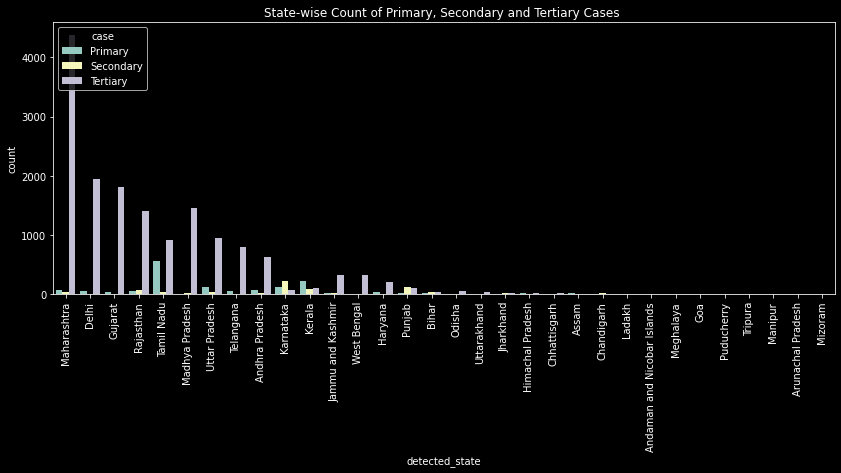

In [74]:
plt.figure(figsize=(14,5))
sns.countplot(x='detected_state',data=clean_ind,hue='case', order=clean_ind.detected_state.value_counts().index)
plt.xticks(rotation=90)
plt.title('State-wise Count of Primary, Secondary and Tertiary Cases ')
plt.show()

In [81]:
ar=clean_ind.detected_state.value_counts().iloc[:5].index.tolist()
ar

['Maharashtra', 'Delhi', 'Gujarat', 'Rajasthan', 'Tamil Nadu']

<font face = "Courier New" size = "3" color=Blue> 
- Top 5 States with maximum number of total cases
    - Maharashtra    | 4483
    - Delhi          | 2003
    - Gujarat        | 1851
    - Rajasthan      | 1535
    - Tamil Nadu     | 1520

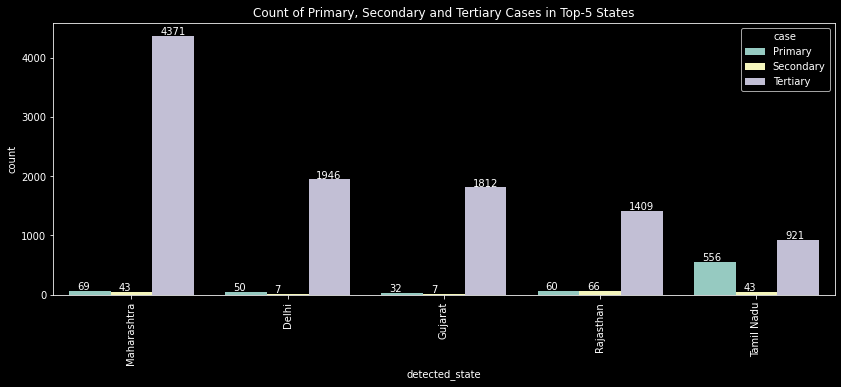

In [83]:
plt.figure(figsize=(14,5))
clean_ind.set_index('detected_state',inplace=True)
top5 = clean_ind.loc[ar,:]
ax=sns.countplot(x=top5.index,hue=top5.case)
plt.xticks(rotation=90)
plt.title('Count of Primary, Secondary and Tertiary Cases in Top-5 States')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2),(p.get_x()+0.05, p.get_height()+20))
clean_ind.reset_index(inplace=True)
plt.show()

In [77]:
pie_chart=top5.groupby('detected_state').case.value_counts()

In [78]:
a=pd.DataFrame(pie_chart)
a.columns = ['number']

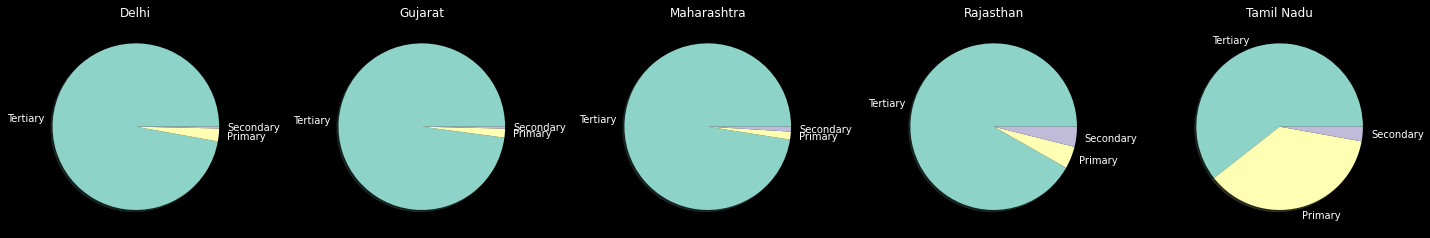

In [79]:
fig,axes = plt.subplots(ncols=5,nrows=1,figsize=(20,5))
for i,j in zip(top5.groupby('detected_state').groups,axes.flat):
    j.pie(a.loc[i,'number'].values,labels=['Tertiary','Primary','Secondary'],shadow=True)
    j.title.set_text(i)
plt.tight_layout()

<font face = "Courier New" size = "3" color=Blue> 
- Tamil Nadu has maximum number of Primary cases 

# Q7
<font face = "Courier New" size = "4" color=deeppink> 

- Find out the number of additional labs needed from the current existing labs:
    - Assume 100 tests per day per lab 
    - Assume increase rate of 10% cases per day from 11.04.2020-20.04.2020
- List out any further assumptions considered.

In [84]:
## Total number of cases until 10th
country_cases.loc['2020-04-10']

ConfirmedIndianNational     6761.0
ConfirmedForeignNational       0.0
Cured                        516.0
Deaths                       206.0
Confirmed                   6761.0
Name: 2020-04-10 00:00:00, dtype: float64

In [85]:
## Defining a new column to see the proportion of positive samples among total samples tested 
icmr['Positive Rate'] = icmr.TotalPositiveCases/icmr.TotalSamplesTested
icmr

,DateTime,TotalSamplesTested,TotalIndividualsTested,TotalPositiveCases,Positive Rate
0,2020-03-13,6500,5900,78,0.012000
5,2020-03-18,13125,12235,150,0.011429
6,2020-03-19,27491,25711,350,0.012731
7,2020-03-20,29780,28000,442,0.014842
8,2020-03-21,32612,30832,586,0.017969
9,2020-03-22,35126,33346,737,0.020982
10,2020-03-23,39090,37310,886,0.022666
11,2020-03-24,43558,41778,1018,0.023371
12,2020-03-25,48072,46292,1120,0.023298


In [86]:
## Old number of labs:
icmr.TotalSamplesTested.sum()/(13*100)

211.81076923076924

In [87]:
#Number of cases at the end of 20th April
(1.1**10)*6761

17536.292772736117

In [88]:
#Number of additional Cases from 11th -20th
17537-6761

10776

<font face = "Courier New" size = "3" color=Blue> 
- Last available positive rate - 0.023298
- Thus, for every 1 sample tested, 0.023298 are positive
- Thus, to find 1 positive sample we must test 1/0.023298 samples
- Therefore to find 10776 positive samples we need to test (1/0.023298)x10776 samples

In [89]:
10776/0.023298

462528.9724439866

<font face = "Courier New" size = "3" color=Blue> 
- Number of tests done by 1 lab in 1 day = 100
- Number of days from 11th-20th = 10
- Number of tests done by 1 lab in 10 days = 1000
- Total number of labs required = 462529/1000
- Number of existing labs = 212
- Therefore, additional number of labs = 463 - 212

In [90]:
463-212

251

<font face = "Courier New" size = "3" color=Blue> 
__ADDITIONAL ASSUMPTIONS__  

Since testing data is available only from 13 March - 25 March, we assume
- The proportion of positive samples does not change from 25 March - 20th April
- The number of labs performing tests from 13 March - 10 th April does not change, all new labs are built after 10th April

# Q8
<font face = "Courier New" size = "4" color=deeppink> 
- Plot the number of cases starting from 1st March - 10th April

In [91]:
march1_april10=country_cases.loc['2020-03-01':'2020-04-10']

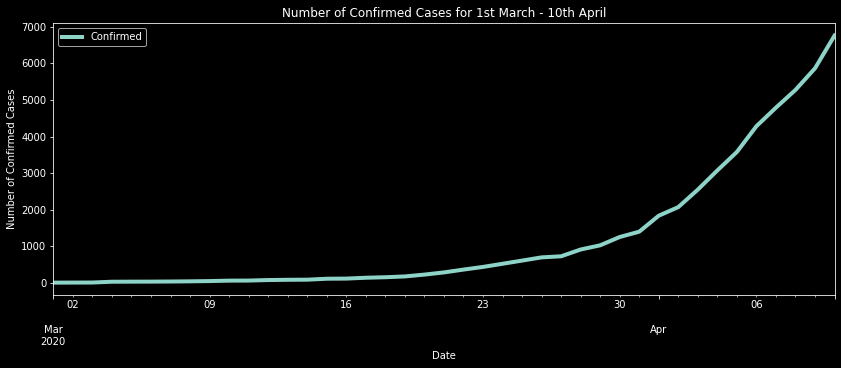

In [92]:
march1_april10.plot(y='Confirmed',figsize=(14,5))
plt.title('Number of Confirmed Cases for 1st March - 10th April')
plt.ylabel('Number of Confirmed Cases')
plt.show()